In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' #omit info 
from learnMSA.msa_hmm import Configuration, Align, Visualize, Clustering
from learnMSA.msa_hmm.SequenceDataset import SequenceDataset
import numpy as np

2024-12-04 15:59:28.231351: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-04 15:59:28.247368: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-04 15:59:28.252276: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
I0000 00:00:1733324369.531045  301853 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1733324369.566636  301853 cuda_executor.cc:1015] succ

## learnMSA demo

In this notebook, we will fit a number of HMM models to a dataset of unaligned sequences. 
We will then use the fitted models to align the sequences and compare the results.
Moreover, we will visualize the best (according to an objective criterion) model and alignment.

*This notebook is meant to be a demo for running learnMSA in Python code. Check the readme if you want to run learnMSA from the command line.* 

Change the variables in the following cell to fit your needs.

In [2]:
# Your fasta file with unaligned sequences.

train_filename = "test/data/egf.fasta"

# Reference file with aligned sequences that have matching IDs to (potentially a subset of) the 
# sequences in the train_file.
# Replace with empty string if no reference is available.
ref_filename = "test/data/egf.ref"

# The number of independently trained models.
num_models = 10

# Use sequence weights based on a rapid pre-clustering of the sequences (requires mmseqs2 to be installed)
use_weights = True

# Align long insertions with an external aligner left unaligned by the main MSA stage (requires famsa to be installed).
align_insertions = True

## Run learnMSA from Python (Training + Viterbi alignment)

Training of 10 models on file egf.fasta
Configuration: 
{
num_models : 10
transitioner : ProfileHMMTransitioner(
 transition_init=
    {
    begin_to_match : DefaultEntry() , match_to_end : DefaultExit() , 
    match_to_match : DefaultMatchTransition(1) , match_to_insert : DefaultMatchTransition(-1) , 
    insert_to_match : Norm(0, 0.1) , insert_to_insert : Norm(-0.5, 0.1) , 
    match_to_delete : DefaultMatchTransition(-1) , delete_to_match : Norm(0, 0.1) , 
    delete_to_delete : Norm(-0.5, 0.1) , left_flank_loop : Norm(0, 0.1) , 
    left_flank_exit : Norm(-1, 0.1) , right_flank_loop : Norm(0, 0.1) , 
    right_flank_exit : Norm(-1, 0.1) , unannotated_segment_loop : Norm(0, 0.1) , 
    unannotated_segment_exit : Norm(-1, 0.1) , end_to_unannotated_segment : Norm(-9, 0.1) , 
    end_to_right_flank : Norm(0, 0.1) , end_to_terminal : Norm(0, 0.1)
    },
 flank_init=Const(0.0),
 prior=ProfileHMMTransitionPrior(match_comp=1, insert_comp=1, delete_comp=1, alpha_flank=7000, alpha_single=100

I0000 00:00:1733324377.161147  301853 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1733324377.161393  301853 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1733324377.161555  301853 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1733324377.161755  301853 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

Epoch 1/10


I0000 00:00:1733324381.495005  301853 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1733324381.495266  301853 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1733324381.495426  301853 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1733324381.495624  301853 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

17/17 - 43s - 3s/step - loss: 98.6667 - loglik: -9.0962e+01 - prior: -7.7043e+00 - aux_loss: 0.0000e+00
Epoch 2/10
17/17 - 3s - 152ms/step - loss: 72.8481 - loglik: -7.0657e+01 - prior: -2.1910e+00 - aux_loss: 0.0000e+00
Epoch 3/10
17/17 - 3s - 153ms/step - loss: 65.7295 - loglik: -6.3797e+01 - prior: -1.9328e+00 - aux_loss: 0.0000e+00
Epoch 4/10
17/17 - 3s - 154ms/step - loss: 64.3100 - loglik: -6.2547e+01 - prior: -1.7626e+00 - aux_loss: 0.0000e+00
Epoch 5/10
17/17 - 3s - 154ms/step - loss: 63.9105 - loglik: -6.2200e+01 - prior: -1.7104e+00 - aux_loss: 0.0000e+00
Epoch 6/10
17/17 - 3s - 153ms/step - loss: 63.7388 - loglik: -6.2042e+01 - prior: -1.6969e+00 - aux_loss: 0.0000e+00
Epoch 7/10
17/17 - 3s - 155ms/step - loss: 63.6424 - loglik: -6.1965e+01 - prior: -1.6770e+00 - aux_loss: 0.0000e+00
Epoch 8/10
17/17 - 3s - 155ms/step - loss: 63.6172 - loglik: -6.1960e+01 - prior: -1.6576e+00 - aux_loss: 0.0000e+00
Epoch 9/10
17/17 - 3s - 154ms/step - loss: 63.5816 - loglik: -6.1934e+01 - pr

I0000 00:00:1733324452.393606  301853 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1733324452.393854  301853 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1733324452.394013  301853 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1733324452.394264  301853 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

expansions model 0: [(12, 2), (13, 2), (15, 2), (16, 1)]
discards model 0: []
expansions model 1: [(12, 9), (13, 1)]
discards model 1: []
expansions model 2: [(12, 2), (13, 3), (18, 1), (19, 2)]
discards model 2: []
expansions model 3: [(12, 2), (14, 2), (19, 1), (20, 2)]
discards model 3: []
expansions model 4: [(12, 2), (13, 3), (14, 1), (17, 1), (18, 1)]
discards model 4: []
expansions model 5: [(12, 9), (13, 1)]
discards model 5: []
expansions model 6: [(12, 2), (13, 3), (14, 1), (17, 1), (18, 1)]
discards model 6: []
expansions model 7: [(12, 7), (13, 1), (14, 1)]
discards model 7: []
expansions model 8: [(12, 7), (13, 1), (14, 1), (16, 2)]
discards model 8: []
expansions model 9: [(12, 3), (13, 3), (14, 1), (15, 1), (16, 1)]
discards model 9: []
Re-initialized the encoder parameters.
Fitting models of lengths [34, 32, 34, 34, 33, 32, 33, 32, 33, 32] on 7774 sequences.
Batch size= 512 Learning rate= 0.1
Using sequence weights  [1.         1.         1.         ... 0.33333334 0.142

I0000 00:00:1733324459.450517  301853 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1733324459.450780  301853 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1733324459.450943  301853 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1733324459.451154  301853 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

Epoch 1/10


I0000 00:00:1733324463.302415  301853 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1733324463.302677  301853 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1733324463.302837  301853 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1733324463.303039  301853 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

17/17 - 43s - 3s/step - loss: 67.4753 - loglik: -5.9861e+01 - prior: -7.6147e+00 - aux_loss: 0.0000e+00
Epoch 2/10
17/17 - 3s - 154ms/step - loss: 59.6093 - loglik: -5.7168e+01 - prior: -2.4410e+00 - aux_loss: 0.0000e+00
Epoch 3/10
17/17 - 3s - 155ms/step - loss: 58.7563 - loglik: -5.6925e+01 - prior: -1.8314e+00 - aux_loss: 0.0000e+00
Epoch 4/10
17/17 - 3s - 156ms/step - loss: 58.4386 - loglik: -5.6842e+01 - prior: -1.5969e+00 - aux_loss: 0.0000e+00
Epoch 5/10
17/17 - 3s - 153ms/step - loss: 58.3821 - loglik: -5.6884e+01 - prior: -1.4977e+00 - aux_loss: 0.0000e+00
Epoch 6/10
17/17 - 3s - 156ms/step - loss: 58.2462 - loglik: -5.6775e+01 - prior: -1.4716e+00 - aux_loss: 0.0000e+00
Epoch 7/10
17/17 - 3s - 152ms/step - loss: 58.2347 - loglik: -5.6787e+01 - prior: -1.4476e+00 - aux_loss: 0.0000e+00
Epoch 8/10
17/17 - 3s - 156ms/step - loss: 58.1994 - loglik: -5.6772e+01 - prior: -1.4278e+00 - aux_loss: 0.0000e+00
Epoch 9/10
17/17 - 3s - 154ms/step - loss: 58.1506 - loglik: -5.6744e+01 - pr

I0000 00:00:1733324535.016591  301853 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1733324535.016847  301853 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1733324535.017009  301853 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1733324535.017218  301853 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

Aligning 2 insertion slices with famsa.
time for generating output: 3.2492
Wrote file test/data/interactive.alignment.fasta
16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 330ms/step
>l=-54.81_t=0.01
..........$CD.....P.....N............P.........CYN.H.G..T..C...S........L......................R....-.AT....G..........Y.TCSCL....PR......Y....TGEH$.......................
>l=-55.61_t=0.01
..........$CD.....S.....Q............P.........CRN.G.-..T..C...Sl.......N......................T....-.NT....D..........Y.TCACF....PG......Y....TGRY$.......................
>l=-45.14_t=0.00
..........$CD.....S.....D............P.........CLN.G.G..T..C...T........L......................R....S.LD....S..........Y.SCACA....PG......Y....TGQH$.......................
>l=-61.25_t=0.01
..........$CD.....H.....V............T.........CLN.G.G..T..C...Q........L......................K....T.LE....D..........Y.TCACA....NG......Y....TGER$.......................
>l=-61.79_t=0.01
..........$CD.....H.....V............T.........CLN.G.G..T..C..

/home/felix/miniforge3/envs/learnMSAdev/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['sequences', 'indices']. Received: the structure of inputs=('*', '*')
  warnings.warn(
I0000 00:00:1733324546.490394  301853 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1733324546.490633  301853 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1733324546.490799  301853 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but the

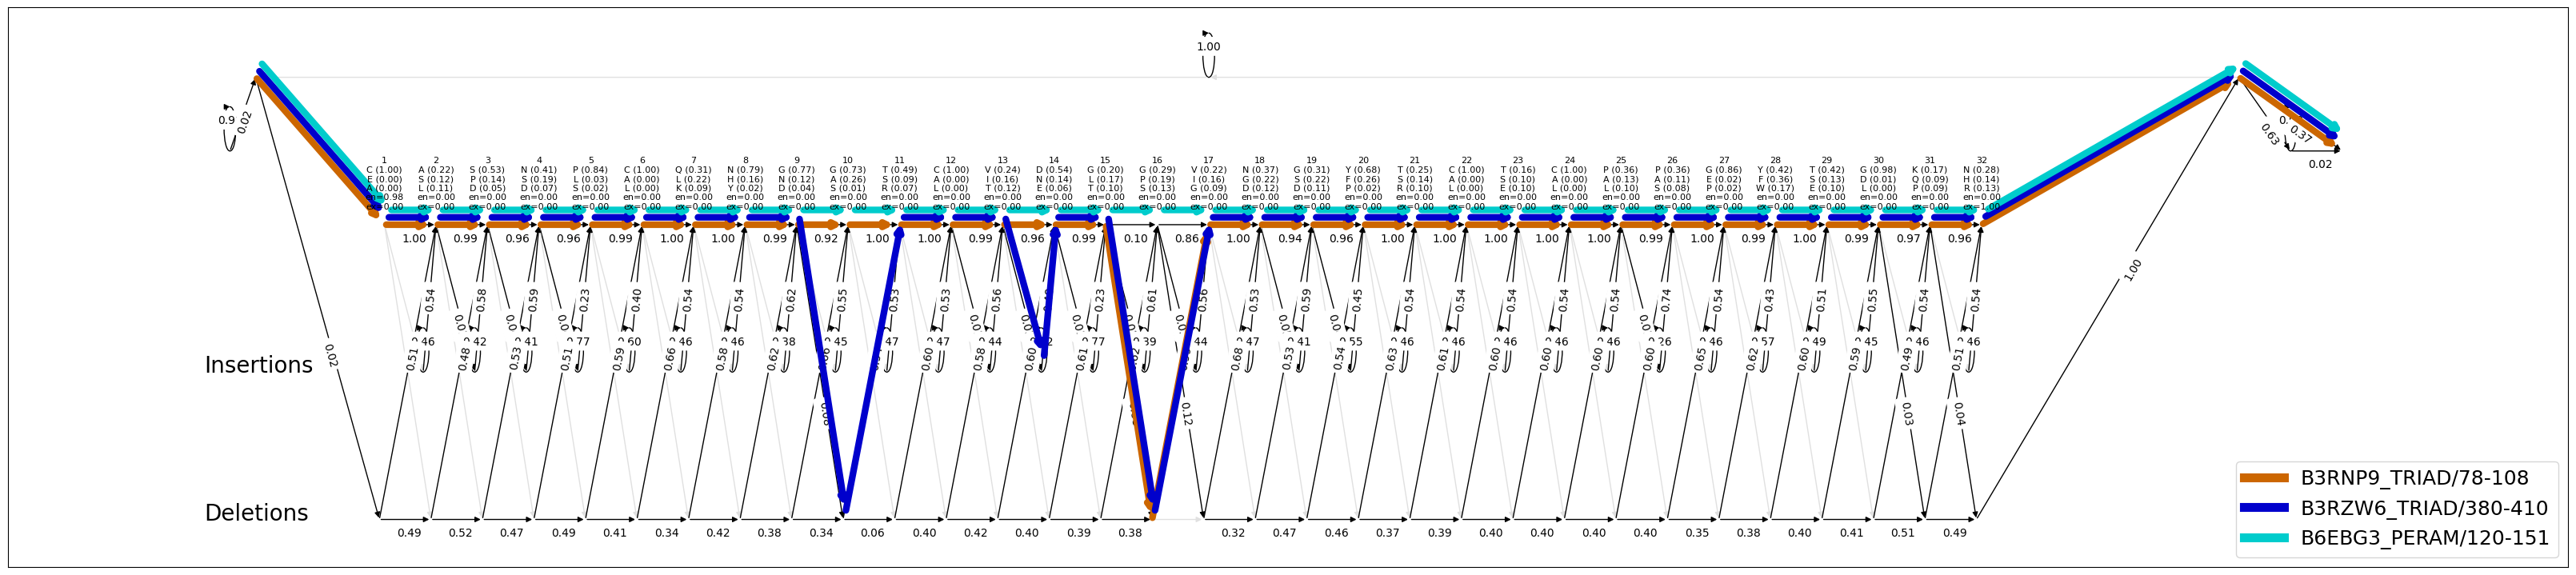

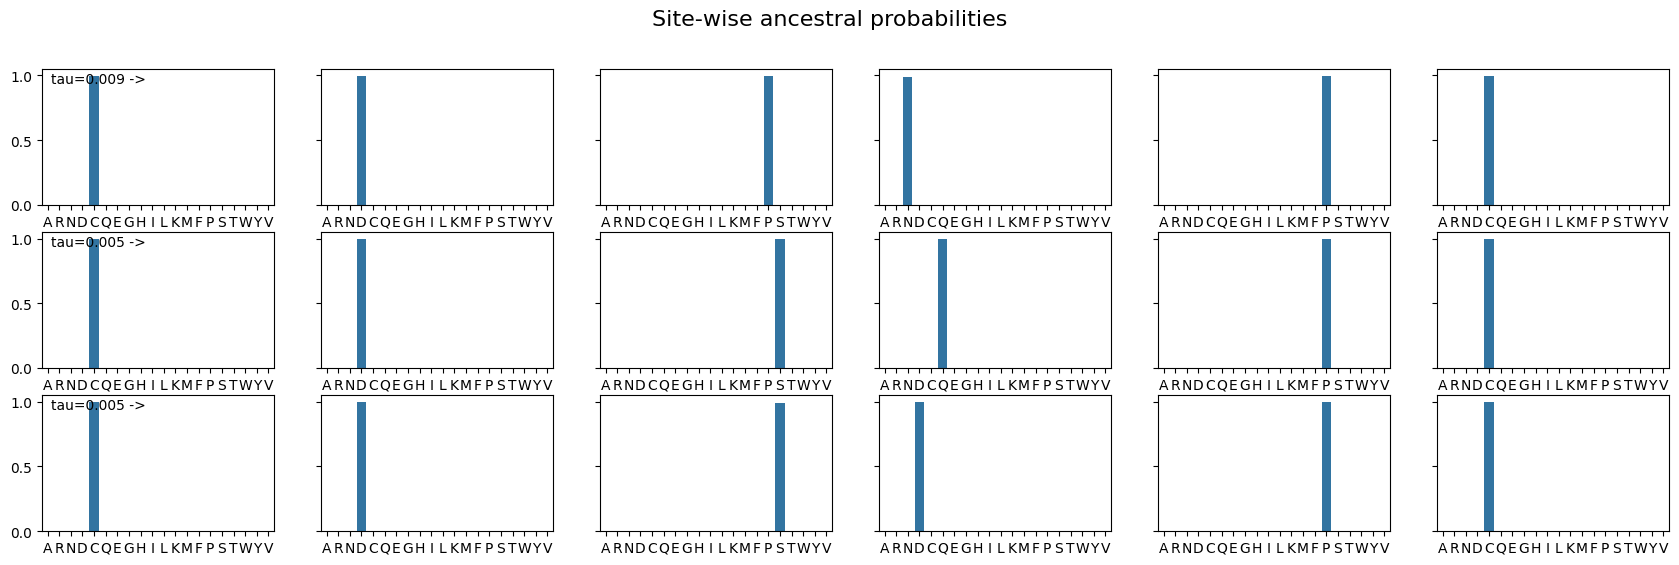

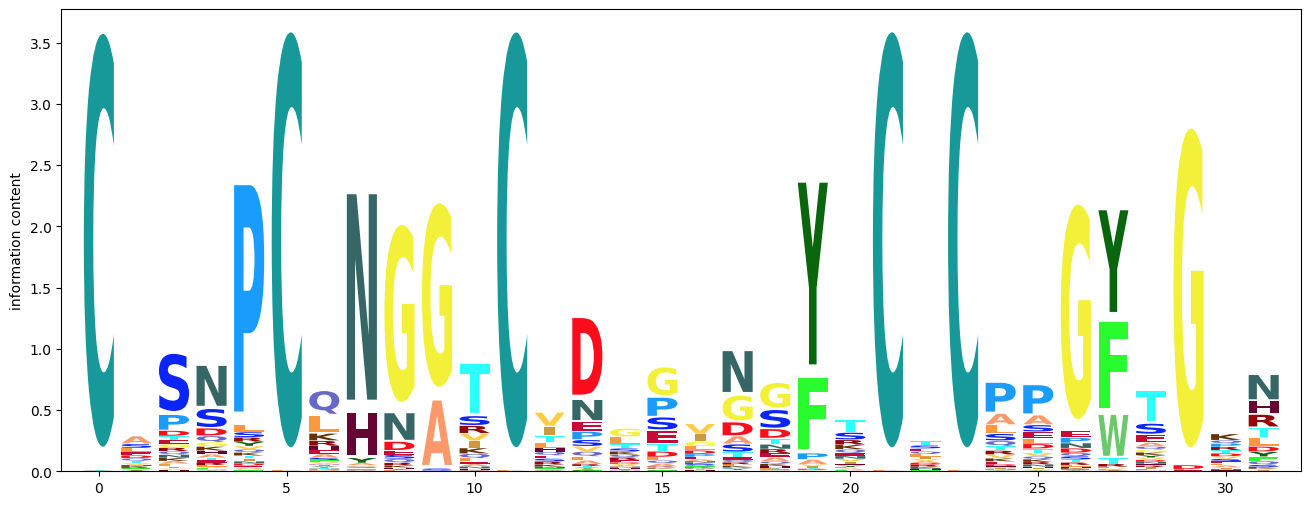

In [3]:
out_filename = "test/data/interactive.alignment.fasta"
config = Configuration.make_default(num_models)
with SequenceDataset(train_filename, fmt="fasta") as data:
    config["crop_long_seqs"] = int(np.ceil(2 * np.mean(data.seq_lens))) #comment out to disable cropping
    config["batch_size"] = 512
    alignment_model = Align.run_learnMSA(data,
                                        out_filename,
                                        config, 
                                        sequence_weights=Clustering.compute_sequence_weights(train_filename, "tmp", config["cluster_seq_id"]) 
                                            if use_weights else None,
                                        verbose=True,
                                        align_insertions=align_insertions)
    Visualize.print_and_plot(alignment_model, alignment_model.best_model)

In [3]:
!id_list=$(sed -n '/^>/p' {ref_filename} | sed 's/^.//') ; export MAX_N_PID_4_TCOFFEE=10000000 ; t_coffee -other_pg seq_reformat -in test/data/interactive.alignment.fasta -action +extract_seq_list ${{id_list[@]}} +rm_gap > test/data/interactive.projection.fasta

HERE: 1ixa
HERE: 1apo
HERE: 1urk
HERE: 1fsb
HERE: 1esl
HERE: 1hre
HERE: 1epi
HERE: 4tgf
HERE: 1hcgb
HERE: 1dan1
HERE: 1dan2
HERE: 1rfnb


In [4]:
!t_coffee -other_pg aln_compare -al1 {ref_filename} -al2 test/data/interactive.projection.fasta -compare_mode sp

*****************************************************
seq1       seq2          Sim   [ALL]           Tot  
egf           12         31.1    73.7 [100.0]   [ 5182]
